# Пример использования библиотеки BigARTM для тематического моделирования

**BigARTM 0.9.0**

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

## Загрузка данных 

**Формат vowpal_wabbit**:
* Каждая строчка документ
* Первое слово - название
* Разделитель |
* Название модальности (text в данном случае)
* Далее данные

In [8]:
with open("data/school.txt") as f:
    print(f.readline()[:60])

 |text межнациональный отношение федерализм россия гг после 


Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель) и сохраняем данные в промежуточных файлах

In [49]:
batch_vectorizer = artm.BatchVectorizer(data_path="data/school.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder="data/school_batches", # папка в которую модель сохранит данные 
                                        batch_size=100,# размер батчей
                                        gather_dictionary=True
                                        ) 

В следующий раз данные можно считывать уже из батчей:

In [42]:
batch_vectorizer = artm.BatchVectorizer(data_path="data/school_batches", 
                                        data_format='batches')

Создаем словарь

In [50]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='data/school_batches')

Аналогично вызову batch_vectorizer.dictionary

## Модель 

### Инициализация  

Создаем объект модели:

In [123]:
T = 10
model_artm = artm.ARTM(num_topics=T, # количество тем 
                       topic_names=["sbj"+str(i) for i in range(T)], 
                       cache_theta=True,
                       class_ids={"text":1}) # название модальности - вес элемента модальности

Добавление метрик

In [124]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',#имя для обращения
                                          dictionary=dictionary)) 

# метрики разреженности
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', 
                                            class_id="text")) #модальности

model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

model_artm.scores.add(artm.TopTokensScore(name="top_words", 
                                          num_tokens=15, 
                                          class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [146]:
model_artm.initialize(batch_vectorizer.dictionary)

### Обучение

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [126]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, 
                       num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

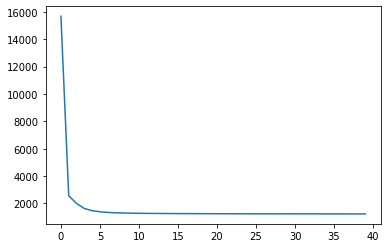

In [127]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)
plt.show()

Выведем топы слов:

In [128]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ')
    print (*model_artm.score_tracker["top_words"].last_tokens[topic_name], sep=" ")

sbj0: 
быть право который ребенок человек язык они семья это русский время для также свой что
sbj1: 
что свой который быть это человек этот его герой она они жизнь ребенок как такой
sbj2: 
предложение слово который что например это как быть или речь такой они если мочь этот
sbj3: 
который что ядро это этот энергия вода земля быть масса атом как температура такой океан
sbj4: 
поэт пушкин что стихотворение который свой это быть звук этот весь лирика год его произведение
sbj5: 
x быть a b число этот при функция уравнение что это для если сила ток
sbj6: 
который человек свой что жизнь его быть герой это как произведение литература этот для русский
sbj7: 
который человек общество развитие социальный государство как политический быть это себя культура жизнь такой отношение
sbj8: 
страна государство население который быть территория этот год являться город африка время что также хозяйство
sbj9: 
быть который год государство война становиться свой что весь первый военный как время период импер

Давайте посмотрим также на разреженность матриц:

In [129]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7677122950553894
0.0018907563062384725


### Регуляризация

В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [130]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=-100, 
                                                            dictionary=batch_vectorizer.dictionary)) # коэффициент частоты слов в коллекции, на который будет домножаться tau
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

Дообучаем модель

In [131]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, 
                       num_collection_passes=15)

Попробуем менять коэффициент регуляризации:

In [132]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

Дообучим с новым коэффициентом

In [133]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, 
                       num_collection_passes=15)

In [134]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ')
    print (*model_artm.score_tracker["top_words"].last_tokens[topic_name], sep=" ")

sbj0: 
право ребенок язык свобода семья английский религиозный гражданский быт суд воспитание честь орган the закреплять
sbj1: 
жить повесть женщина нет лермонтов поэма написать школа молодой сказка отец хороший любить гоголь умирать
sbj2: 
слово например предложение простой какой предмет речь глагол скорость физика имя выступать свет кто живой
sbj3: 
земля энергия вода ядро масса движение природный состоять океан частица атом заряд температура располагать южный
sbj4: 
пушкин поэт стихотворение звук лирика писать стих поэзия сравнение почти русь ночь былина красота любовный
sbj5: 
при x a сила если два число можно b функция пример получать тело равный случай
sbj6: 
человек его жизнь герой русский главный произведение мир литература сам история автор литературный личность всегда
sbj7: 
общество представлять развитие отношение социальный политический процесс форма система экономический производство культура характер понятие роль
sbj8: 
страна территория население город древний северный м

In [135]:
# еще раз посмотрим на разреженность
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9007267355918884
0.09810924530029297


Маленький коэффициент - не будет влиять на модель, большой - занулит все веса.

Обратите внимание, что разреживать модель рекомендуется только **после того, как она сошлась без регуляризации**.

Сохранение и загрузка модели:

In [ ]:
model_artm.save("my_model")

In [ ]:
T = 10
model_artm = artm.ARTM(num_topics=T, 
                       topic_names=["sbj"+str(i) for i in range(T)], 
                       cache_theta=True,
                       class_ids={"text":1}) 
model_artm.load("my_model")

### Матрицы разложения 

Можно попросить матрицы в чистом виде:

In [136]:
phi = model_artm.get_phi()

In [137]:
phi.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, скандальный)",0.0,0.000138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, проучивать)",0.0,0.000138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, бойкот)",0.0,0.000138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, заступаться)",0.0,0.000138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, допрос)",0.0,0.000138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Матрица вероятностей тем в документах.

In [138]:
theta = model_artm.get_theta()
theta

,400,401,402,403,404,405,406,407,408,409,...,190,191,192,193,194,195,196,197,198,199
sbj0,0.008511,0.019512,0.031963,0.143272,0.104651,0.000000,0.017862,0.000000,0.013216,0.022766,...,1.408450e-02,0.008299,0.286147,0.112905,0.010753,0.484548,0.027559,0.000000,0.005000,0.006993
sbj1,0.034043,0.152014,0.018265,0.009747,0.017442,0.000000,0.039648,0.005051,0.015648,0.010989,...,0.000000e+00,0.012448,0.014578,0.031963,0.011237,0.000000,0.043307,0.004184,0.164809,0.006993
sbj2,0.127660,0.021898,0.000000,0.093907,0.017442,0.011050,0.558912,0.035354,0.008811,0.696911,...,2.564251e-02,0.008299,0.061594,0.036530,0.007168,0.008845,0.012185,0.020921,0.020000,0.020979
sbj3,0.059575,0.007485,0.009132,0.016026,0.017624,0.000000,0.039813,0.636363,0.030837,0.000000,...,2.175830e-02,0.638961,0.090580,0.045662,0.025593,0.004405,0.031496,0.627257,0.030191,0.000000
sbj4,0.009244,0.327729,0.000000,0.019231,0.000000,0.000000,0.013369,0.005051,0.008811,0.000000,...,1.697174e-09,0.008299,0.010870,0.009132,0.000000,0.004405,0.000000,0.000000,0.030000,0.000000
sbj5,0.624798,0.031630,0.022831,0.656920,0.040698,0.950276,0.074890,0.146465,0.030837,0.082418,...,7.511732e-02,0.082987,0.065217,0.036530,0.032258,0.088106,0.031496,0.192469,0.065000,0.853147
sbj6,0.080851,0.114631,0.022831,0.012821,0.067630,0.016575,0.114537,0.035354,0.066666,0.060440,...,1.596243e-01,0.012491,0.090580,0.388128,0.046595,0.074890,0.043502,0.004199,0.525000,0.034965
sbj7,0.021277,0.035364,0.123288,0.012821,0.685864,0.011050,0.092511,0.055556,0.074890,0.098901,...,6.286557e-01,0.020747,0.170290,0.127854,0.189964,0.207048,0.090551,0.067289,0.085000,0.041958
sbj8,0.017021,0.018258,0.036530,0.009615,0.000000,0.000000,0.017621,0.025253,0.213577,0.016588,...,9.389665e-03,0.149377,0.134058,0.118721,0.282367,0.013216,0.062992,0.016736,0.015000,0.020979
sbj9,0.017021,0.271479,0.735160,0.025641,0.048649,0.011050,0.030837,0.055556,0.536707,0.010989,...,6.572766e-02,0.058091,0.076087,0.092574,0.394064,0.114537,0.656911,0.066946,0.060000,0.013986


### Предсказания для новых данных 

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [140]:
theta_test = model_artm.transform(batch_vectorizer)

In [145]:
theta_test

,400,401,402,403,404,405,406,407,408,409,...,190,191,192,193,194,195,196,197,198,199
sbj0,0.008511,0.019512,0.031964,0.143271,0.104651,0.000000,0.017862,0.000000,0.013216,0.022764,...,1.408452e-02,0.008299,0.286147,0.112895,0.010753,0.484547,0.027559,0.000000,0.00500,0.006993
sbj1,0.034043,0.152023,0.018265,0.009747,0.017442,0.000000,0.039648,0.005051,0.017793,0.010989,...,0.000000e+00,0.012448,0.014578,0.031963,0.011237,0.000000,0.043307,0.004184,0.16481,0.006993
sbj2,0.127660,0.021898,0.000000,0.093908,0.017442,0.011050,0.558916,0.035354,0.008811,0.696912,...,2.569757e-02,0.008299,0.061594,0.036530,0.007168,0.008845,0.012185,0.020920,0.02000,0.020979
sbj3,0.059574,0.007486,0.009132,0.016026,0.017624,0.000000,0.039809,0.636363,0.030837,0.000000,...,2.170485e-02,0.638961,0.090580,0.045662,0.025599,0.004405,0.031496,0.627256,0.03019,0.000000
sbj4,0.009246,0.327733,0.000000,0.019231,0.000000,0.000000,0.013369,0.005051,0.008811,0.000000,...,1.687502e-09,0.008299,0.010870,0.009132,0.000000,0.004405,0.000000,0.000000,0.03000,0.000000
sbj5,0.624797,0.031630,0.022831,0.656920,0.040698,0.950276,0.074890,0.146465,0.030837,0.082418,...,7.511744e-02,0.082987,0.065217,0.036530,0.032258,0.088106,0.031496,0.192469,0.06500,0.853147
sbj6,0.080851,0.114625,0.022831,0.012821,0.067559,0.016575,0.114537,0.035354,0.066641,0.060440,...,1.596245e-01,0.012491,0.090580,0.388128,0.046595,0.074890,0.043502,0.004199,0.52500,0.034965
sbj7,0.021277,0.035364,0.123288,0.012821,0.685864,0.011050,0.092511,0.055556,0.074890,0.098901,...,6.286536e-01,0.020747,0.170290,0.127854,0.189964,0.207048,0.090551,0.067290,0.08500,0.041958
sbj8,0.017021,0.018248,0.036530,0.009615,0.000000,0.000000,0.017621,0.025253,0.211454,0.016588,...,9.389678e-03,0.149377,0.134058,0.118722,0.282360,0.013216,0.062992,0.016736,0.01500,0.020979
sbj9,0.017021,0.271481,0.735159,0.025641,0.048720,0.011050,0.030837,0.055556,0.536712,0.010989,...,6.572775e-02,0.058091,0.076087,0.092584,0.394066,0.114537,0.656912,0.066946,0.06000,0.013986


In [ ]:
|